# Goal of this project

One of the painpoints of every for hire vehicle company like Uber, is that sometimes drivers are not around when people need them. 

The goal of this project is to come up with solutions to this, aka, figuring out the hot zones in a specific city (here New York).

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from datetime import datetime
import matplotlib.pyplot as plt

# Getting the Data
Data was collected from NYC Taxi and Limousine Commission after FiveThirtyEight submitted a Freedom of Information Law request on July 20, 2015 [1]. More recent data can be found on NY city website [2].

[1] : https://github.com/fivethirtyeight/uber-tlc-foil-response/
[2] : https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page

In this notebook, data from Uber for the month of April 2014 will be analyzed.

In [3]:
df = pd.read_csv('dataset/uber-raw-data-apr14.csv', parse_dates = [0])

# Exploring the data

In [4]:
df.head()

,Date/Time,Lat,Lon,Base
0,2014-04-01 00:11:00,40.7690,-73.9549,B02512
1,2014-04-01 00:17:00,40.7267,-74.0345,B02512
2,2014-04-01 00:21:00,40.7316,-73.9873,B02512
3,2014-04-01 00:28:00,40.7588,-73.9776,B02512
4,2014-04-01 00:33:00,40.7594,-73.9722,B02512


In [5]:
df.describe(include = 'all', datetime_is_numeric=True)

,Date/Time,Lat,Lon,Base
count,564516,564516.000000,564516.000000,564516
unique,NaN,NaN,NaN,5
top,NaN,NaN,NaN,B02682
freq,NaN,NaN,NaN,227808
mean,2014-04-16 17:46:01.296261120,40.740005,-73.976817,NaN
min,2014-04-01 00:00:00,40.072900,-74.773300,NaN
25%,2014-04-08 16:27:00,40.722500,-73.997700,NaN
50%,2014-04-16 19:19:00,40.742500,-73.984800,NaN
75%,2014-04-24 22:14:00,40.760700,-73.970000,NaN
max,2014-04-30 23:59:00,42.116600,-72.066600,NaN


In our raw data, we observe that there are 564,516 trips performed during the month of April 2014. Uber had 5 unique bases with the most active being B02682

Let's make some data vizualizations to explore further the dataset.

### Exploring the bases data

B02682    227808
B02598    183263
B02617    108001
B02512     35536
B02764      9908
Name: Base, dtype: int64

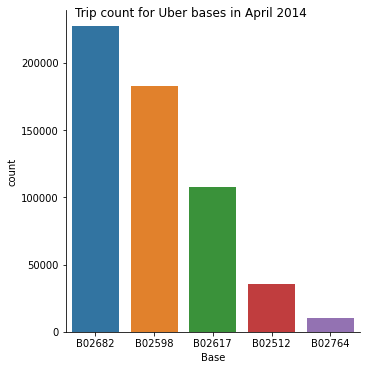

In [6]:
bases = df.Base.value_counts(dropna = False)

display(bases)
b = sns.catplot(data = df, x = 'Base', kind = 'count', order = bases.index)

b.fig.suptitle('Trip count for Uber bases in April 2014') 
plt.show()

There are 5 main bases, the most active is B02682 (227,808 trips) and the least active is B02764 with 9908 trips performed in April 2014.

### Exploring the Date/Time data
What time did the trips occur the most ? 

In [7]:
df['Date/Time'].dt.day_name().value_counts()

Wednesday    108631
Tuesday       91185
Friday        90303
Thursday      85067
Saturday      77218
Monday        60861
Sunday        51251
Name: Date/Time, dtype: int64

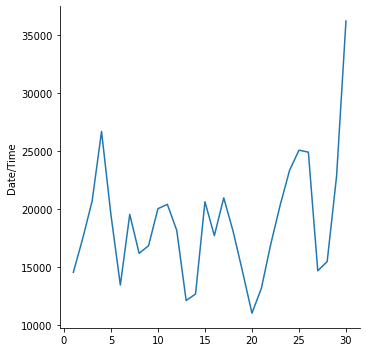

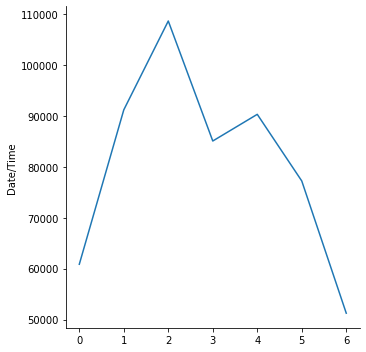

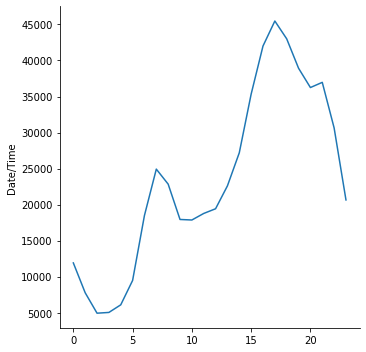

In [8]:
dt1 = sns.relplot(data = df['Date/Time'].dt.day.value_counts(), kind = 'line' )
dt2 = sns.relplot(data = df['Date/Time'].dt.dayofweek.value_counts(), 
                  kind = 'line' )
dt3 = sns.relplot(data = df['Date/Time'].dt.hour.value_counts(), 
                  kind = 'line' )
plt.show()

We see there is some seasonality in the total number of daily trips. The number of trips increases a lot at the end of the month.
Wednesday seems to be the day with the most trip count, followed by Tuesday. Sunday and Monday are the days with less activity.
Main rush hour seems to be between 16:00 and 20:00, with another 'smaller' rush hour between 07:00 and 08:00. These are probably influenced by daily commute of employees to their workplace.

Let's enrich our dataframe with relevant date/time features

In [9]:
df['day_of_week'] = df['Date/Time'].dt.dayofweek
df['day'] = df['Date/Time'].dt.day
df['hour'] = df['Date/Time'].dt.hour
df['minute'] = df['Date/Time'].dt.minute
df['quarter'] = df['Date/Time'].dt.quarter #useful if using more data - a year for instance

In [10]:
df.head()

,Date/Time,Lat,Lon,Base,day_of_week,day,hour,minute,quarter
0,2014-04-01 00:11:00,40.7690,-73.9549,B02512,1,1,0,11,2
1,2014-04-01 00:17:00,40.7267,-74.0345,B02512,1,1,0,17,2
2,2014-04-01 00:21:00,40.7316,-73.9873,B02512,1,1,0,21,2
3,2014-04-01 00:28:00,40.7588,-73.9776,B02512,1,1,0,28,2
4,2014-04-01 00:33:00,40.7594,-73.9722,B02512,1,1,0,33,2


In [15]:
mapbox_access_token = open(".mapbox_token").read() # private token
px.set_mapbox_access_token(mapbox_access_token)

fig = px.scatter_mapbox(df, 
                        lat="Lat", lon="Lon", 
                        hover_name="Base", 
                        zoom=10, 
                        mapbox_style="light")

fig.show(renderer="iframe")

# Modeling the data

Now we will use Location information and KMeans clustering technique in order to find some underlying structure and patterns within the data

In [16]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import MiniBatchKMeans

X = df.loc[:, ['Lat', 'Lon']]
sc = StandardScaler()
X_scaled = sc.fit_transform(X)

mbkmeans = MiniBatchKMeans(n_clusters = 15) #number of clusters predefined
mbkmeans.fit(X_scaled)

display(mbkmeans.cluster_centers_)

array([[-0.33512862, -0.43015004],
       [ 0.84751022,  0.41382914],
       [-2.32800983,  4.16320685],
       [ 7.162936  ,  5.150477  ],
       [-3.34088279, -0.04439627],
       [-1.66457374, -0.01412191],
       [ 0.09648822, -0.34157153],
       [ 1.36072257,  0.22481791],
       [ 0.78920846,  2.45134428],
       [-0.7856524 , -0.61914248],
       [-0.959763  ,  0.63947096],
       [ 0.72093483, -0.31155133],
       [ 3.09451146,  1.24334883],
       [-1.15894854, -4.00132259],
       [ 0.47707771,  0.00946875]])

In [17]:
mbkmeans.cluster_centers_

array([[-0.33512862, -0.43015004],
       [ 0.84751022,  0.41382914],
       [-2.32800983,  4.16320685],
       [ 7.162936  ,  5.150477  ],
       [-3.34088279, -0.04439627],
       [-1.66457374, -0.01412191],
       [ 0.09648822, -0.34157153],
       [ 1.36072257,  0.22481791],
       [ 0.78920846,  2.45134428],
       [-0.7856524 , -0.61914248],
       [-0.959763  ,  0.63947096],
       [ 0.72093483, -0.31155133],
       [ 3.09451146,  1.24334883],
       [-1.15894854, -4.00132259],
       [ 0.47707771,  0.00946875]])

In [18]:
# adding cluster information the the dataframe
df['cluster'] = mbkmeans.labels_

# count of trips in each cluster
display(df.cluster.value_counts())
size_dict = df.cluster.value_counts().to_dict()

# Cluster centers location
geo_cluster_centers = pd.DataFrame(sc.inverse_transform(mbkmeans.cluster_centers_), columns = ['Lat', 'Lon'])
geo_cluster_centers['Size'] = pd.DataFrame.from_dict(size_dict, orient = 'index')
display(geo_cluster_centers)

# IF CASE WE USE OTHER FEATURES FOR CLUSTERING
# Clustering takes into account more than just geographic info. Thus the cluster_centers_ does not represent the geographic cluster center.
#geo_cluster_centers = df.groupby('cluster')[['Lat', 'Lon']].mean()
#geo_cluster_centers

0     107879
14    105188
6     102516
9      47024
1      42365
11     36189
5      27861
7      27172
10     25691
8      14078
2      13347
12      5273
13      4756
4       4255
3        922
Name: cluster, dtype: int64

,Lat,Lon,Size
0,40.727913,-73.998507,107879
1,40.770586,-73.955949,42365
2,40.656003,-73.766884,13347
3,40.998467,-73.717100,922
4,40.619456,-73.979056,4255
5,40.679942,-73.977529,27861
6,40.743487,-73.994041,102516
7,40.789104,-73.965480,27172
8,40.768482,-73.853206,14078
9,40.711656,-74.008038,47024


Now let's visualize the clusters obtained using Plotly animation.

In [19]:
df.head()

,Date/Time,Lat,Lon,Base,day_of_week,day,hour,minute,quarter,cluster
0,2014-04-01 00:11:00,40.7690,-73.9549,B02512,1,1,0,11,2,1
1,2014-04-01 00:17:00,40.7267,-74.0345,B02512,1,1,0,17,2,9
2,2014-04-01 00:21:00,40.7316,-73.9873,B02512,1,1,0,21,2,0
3,2014-04-01 00:28:00,40.7588,-73.9776,B02512,1,1,0,28,2,14
4,2014-04-01 00:33:00,40.7594,-73.9722,B02512,1,1,0,33,2,14


In [21]:
mapbox_access_token = open(".mapbox_token").read() # private token
px.set_mapbox_access_token(mapbox_access_token)

fig = px.scatter_mapbox(df, 
                        lat="Lat", lon="Lon",  
                        color=mbkmeans.labels_, 
                        zoom=9, 
                        mapbox_style="light",
                        animation_frame="hour"
                       )

fig.show(renderer="iframe")

In [22]:
site_lat = df.Lat
site_lon = df.Lon
locations_name = df.cluster

mapbox_access_token = open(".mapbox_token").read() # private token

fig = go.Figure()

# points representing the trip, color represents the cluster
fig.add_trace(go.Scattermapbox(
        lat=df['Lat'],
        lon=df['Lon'],
        mode='markers',
        marker=go.scattermapbox.Marker(
            size=2,
            color=df['cluster'],
            opacity=0.7
        ),
        text=locations_name,
        hoverinfo='none'
    ))


# cluster centers
fig.add_trace(go.Scattermapbox(
        lat=geo_cluster_centers['Lat'],
        lon=geo_cluster_centers['Lon'],
        mode='markers',
        text=geo_cluster_centers.Size, 
        hoverinfo='text',
        hovertemplate = 'Trip count: %{text}<extra></extra>',
        marker = {'size' : 15, 'symbol': "marker", 'color' : 'white'},
        #marker=dict(symbol ='marker', size=15, color='blue')
    ))

fig.update_layout(
    title='Uber pickup hot zones centers in New York City',
    autosize=True,
    hovermode='closest',
    showlegend=False,
    mapbox=dict(
        accesstoken=mapbox_access_token,
        bearing=0,
        center=dict(
            lat=site_lat.mean(),
            lon=site_lon.mean()
        ),
        pitch=0,
        zoom=9,
        style='light'
    ),
)

fig.show(renderer="iframe")

The map above shows the different clusters of the hot zones in NYC and their centers. Each color reprensents a different cluster.
In the following cells, we'll use Lat/Lon data to determine more info about the location (neighborhood, suburb) using Geopy.

### Experimenting with Geopy

Geopy is a Python client for several popular geocoding web services.
Geopy makes it easy for Python developers to locate the coordinates of addresses, cities, countries, and landmarks across the globe using third-party geocoders and other data sources. [Source : https://geopy.readthedocs.io/en/latest/]

In [23]:
pip install geopy

Note: you may need to restart the kernel to use updated packages.


In [24]:
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent= "example app")
location = geolocator.reverse(str(df['Lat'][0])+','+str(df['Lon'][0]))
print(location.address)

400, East 74th Street, Upper East Side, Manhattan Community Board 8, Manhattan, New York County, New York, 10021, United States


In [25]:
location.raw#.get('address').get('suburb')

{'place_id': 28312380,
 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. https://osm.org/copyright',
 'osm_type': 'node',
 'osm_id': 2723728796,
 'lat': '40.768901',
 'lon': '-73.9547764',
 'display_name': '400, East 74th Street, Upper East Side, Manhattan Community Board 8, Manhattan, New York County, New York, 10021, United States',
 'address': {'house_number': '400',
  'road': 'East 74th Street',
  'quarter': 'Upper East Side',
  'neighbourhood': 'Manhattan Community Board 8',
  'suburb': 'Manhattan',
  'county': 'New York County',
  'city': 'New York',
  'state': 'New York',
  'postcode': '10021',
  'country': 'United States',
  'country_code': 'us'},
 'boundingbox': ['40.768851', '40.768951', '-73.9548264', '-73.9547264']}

We see that geopy enables to access new information like road, quarter, neighborhood, suburb, country, state, etc.
We will update the geo_cluster_centers dataframe to include new neighborhood and suburb data using geopy.

In [27]:
def coord(dataf):
    return(str(dataf['Lat'])+','+str(dataf['Lon']))

In [28]:
geo_cluster_centers['coord'] = geo_cluster_centers.apply(coord, axis = 1)
geo_cluster_centers

,Lat,Lon,Size,coord
0,40.727913,-73.998507,107879,"40.727912703583065,-73.99850749185667"
1,40.770586,-73.955949,42365,"40.770586065573774,-73.95594918032786"
2,40.656003,-73.766884,13347,"40.65600322580645,-73.76688387096775"
3,40.998467,-73.717100,922,"40.998466666666666,-73.71709999999999"
4,40.619456,-73.979056,4255,"40.619455555555554,-73.97905555555556"
5,40.679942,-73.977529,27861,"40.67994210526316,-73.97752894736843"
6,40.743487,-73.994041,102516,"40.74348680851064,-73.99404085106383"
7,40.789104,-73.965480,27172,"40.7891043956044,-73.96548021978022"
8,40.768482,-73.853206,14078,"40.76848235294118,-73.85320588235294"
9,40.711656,-74.008038,47024,"40.71165637583893,-74.00803758389262"


In [29]:
geo_cluster_centers['l_neighb'] = geo_cluster_centers.apply(lambda d: geolocator.reverse(d['coord']).raw.get('address').get('neighbourhood'), axis = 1)
geo_cluster_centers['l_suburb'] = geo_cluster_centers.apply(lambda d: geolocator.reverse(d['coord']).raw.get('address').get('suburb'), axis = 1)

In [30]:
geo_cluster_centers

,Lat,Lon,Size,coord,l_neighb,l_suburb
0,40.727913,-73.998507,107879,"40.727912703583065,-73.99850749185667",Manhattan Community Board 2,Manhattan
1,40.770586,-73.955949,42365,"40.770586065573774,-73.95594918032786",Manhattan Community Board 8,Manhattan
2,40.656003,-73.766884,13347,"40.65600322580645,-73.76688387096775",None,Queens
3,40.998467,-73.717100,922,"40.998466666666666,-73.71709999999999",None,None
4,40.619456,-73.979056,4255,"40.619455555555554,-73.97905555555556",Bath Beach,Brooklyn
5,40.679942,-73.977529,27861,"40.67994210526316,-73.97752894736843",Park Slope,Brooklyn
6,40.743487,-73.994041,102516,"40.74348680851064,-73.99404085106383",Flatiron District,Manhattan
7,40.789104,-73.965480,27172,"40.7891043956044,-73.96548021978022",None,Manhattan
8,40.768482,-73.853206,14078,"40.76848235294118,-73.85320588235294",None,Queens
9,40.711656,-74.008038,47024,"40.71165637583893,-74.00803758389262",Civic Center,Manhattan


In the updated dataframe above, we now have access to neighborhood and suburb information that we will show in our map for more clarity.
It is to be noted that some neighborhoods/suburbs are not identified by geopy. This may be explained by some cluster centers that are inside the water, or outside the city (near airports...)

In [50]:
site_lat = df.Lat
site_lon = df.Lon
locations_name = df.cluster

#information to show when hover the cluster centers
geo_cluster_centers['text'] = '<br>Cluster number : ' + (geo_cluster_centers.index).astype(str) + '<br>Trip count : ' + (geo_cluster_centers['Size']).astype(str) +'<br>Neighbourhood :' + (geo_cluster_centers['l_neighb']).astype(str)+ '<br>Suburb :' + (geo_cluster_centers['l_suburb']).astype(str)
    
mapbox_access_token = open(".mapbox_token").read() # private token

fig = go.Figure()

# points representing the trip, color represents the cluster
fig.add_trace(go.Scattermapbox(
        lat=df['Lat'],
        lon=df['Lon'],
        mode='markers',
        marker=go.scattermapbox.Marker(
            size=2,
            color=df['cluster'],
            opacity=0.7
        ),
        text=locations_name,
        hoverinfo='none'
    ))


# cluster centers
fig.add_trace(go.Scattermapbox(
        lat=geo_cluster_centers['Lat'],
        lon=geo_cluster_centers['Lon'],
        mode='markers',
        text=geo_cluster_centers.text, 
        hoverinfo='text',
        marker = {'size' : 15, 'symbol': "marker", 'color' : 'white'},
    ))




fig.update_layout(
    title='Uber pickup hot zones centers in New York City in April 2014',
    autosize=True,
    hovermode='closest',
    showlegend=False,
    mapbox=dict(
        accesstoken=mapbox_access_token,
        bearing=0,
        center=dict(
            lat=site_lat.mean(),
            lon=site_lon.mean()
        ),
        pitch=0,
        zoom=9,
        style='light'
    ),
)

fig.show(renderer="iframe")

In [51]:
import plotly.io as pio

pio.write_html(fig, "uberpickup.html")

In [33]:
geo_cluster_centers

,Lat,Lon,Size,coord,l_neighb,l_suburb,text
0,40.727913,-73.998507,107879,"40.727912703583065,-73.99850749185667",Manhattan Community Board 2,Manhattan,<br>Cluster number : 0<br>Trip count : 107879<...
1,40.770586,-73.955949,42365,"40.770586065573774,-73.95594918032786",Manhattan Community Board 8,Manhattan,<br>Cluster number : 1<br>Trip count : 42365<b...
2,40.656003,-73.766884,13347,"40.65600322580645,-73.76688387096775",None,Queens,<br>Cluster number : 2<br>Trip count : 13347<b...
3,40.998467,-73.717100,922,"40.998466666666666,-73.71709999999999",None,None,<br>Cluster number : 3<br>Trip count : 922<br>...
4,40.619456,-73.979056,4255,"40.619455555555554,-73.97905555555556",Bath Beach,Brooklyn,<br>Cluster number : 4<br>Trip count : 4255<br...
5,40.679942,-73.977529,27861,"40.67994210526316,-73.97752894736843",Park Slope,Brooklyn,<br>Cluster number : 5<br>Trip count : 27861<b...
6,40.743487,-73.994041,102516,"40.74348680851064,-73.99404085106383",Flatiron District,Manhattan,<br>Cluster number : 6<br>Trip count : 102516<...
7,40.789104,-73.965480,27172,"40.7891043956044,-73.96548021978022",None,Manhattan,<br>Cluster number : 7<br>Trip count : 27172<b...
8,40.768482,-73.853206,14078,"40.76848235294118,-73.85320588235294",None,Queens,<br>Cluster number : 8<br>Trip count : 14078<b...
9,40.711656,-74.008038,47024,"40.71165637583893,-74.00803758389262",Civic Center,Manhattan,<br>Cluster number : 9<br>Trip count : 47024<b...


In [37]:
geo_cluster_centers.groupby('l_suburb', dropna = False).agg('sum')

,Lat,Lon,Size
l_suburb,,,
Brooklyn,122.004772,-221.901156,57807
Manhattan,285.265985,-517.890882,468333
Queens,81.424486,-147.620090,27425
The Bronx,40.851665,-73.914120,5273
NaN,81.696653,-147.895687,5678


In [46]:
(geo_cluster_centers
 .groupby('l_suburb', dropna = False)
 .agg({'Size' : 'sum'})
 .sort_values(by = 'Size', ascending = False)
 .rename(columns = {'Size' : 'trip_count'})
 .assign(percentage = lambda d: np.round(d['trip_count']/sum(d['trip_count']), 2))
)

,trip_count,percentage
l_suburb,,
Manhattan,468333,0.83
Brooklyn,57807,0.10
Queens,27425,0.05
NaN,5678,0.01
The Bronx,5273,0.01


# Conclusion

Above is the updated map and trip count per suburb. Neighborhood, suburb and trip count are all included for each cluster. 
This analysis shows the hotzones in NYC. Manhattan (83% of requests) is the area with the most professional and leisure activities (shopping, cinemas, restaurants) thus traffic and pickup requests are naturally higher there. But it is also important not to neglect areas in the suburbs like Brooklyn (10%) and Queens (5%) and around airports where the requests are more scattered.

# Next steps

In this analysis, only data from the month of april 2014 was considered. 
* A good thing would be to further analyze the impact of hour/day on the traffic.
* Also another idea would be to analyze the evolution and the patterns of the pickup requests over a year. 
* It can be also interesting to explore the impact of COVID on the pickup requests by analyzing the data for the same month (e.g april) from 2014->2020. The data is available on NYC website.
* Finally, there are other data available about taxis and other FHV companies. It could be interesting to compare the interactions and market share between the different parts